In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkFiles

In [23]:
spark = SparkSession.getActiveSession()
if spark is not None:
    spark.stop()
    print("Stopped the existing SparkSession.")

In [2]:
if SparkSession.getActiveSession() is not None:
    print("An active SparkSession exists.")
else:
    print("No active SparkSession.")

No active SparkSession.


In [16]:
# import pandas as pd

# df = pd.read_csv('city_temperature.csv')
# df.head()

In [3]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("SparkSession2") \
    .master("spark://192.168.210.133:7077") \
    .config("fs.defaultFS", "hdfs://192.168.210.133:9000") \
    .config("spark.hadoop.fs.hdfs.impl", "org.apache.hadoop.hdfs.DistributedFileSystem") \
    .config("spark.hadoop.fs.file.impl", "org.apache.hadoop.fs.LocalFileSystem") \
    .config("spark.executor.memory", "2g") \
    .config("spark.executor.cores", "2") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .config("spark.network.timeout", "300s") \
    .config("spark.hadoop.fs.hdfs.impl.disable.cache", "true") \
    .getOrCreate()
if SparkSession.getActiveSession() is not None:
    print("Session successfully started")

24/12/02 13:14:00 WARN Utils: Your hostname, Jenos-MacBook-Pro-5387.local resolves to a loopback address: 127.0.0.1; using 192.168.210.133 instead (on interface en0)
24/12/02 13:14:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/02 13:14:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Session successfully started


In [4]:
# spark_df = spark.read.csv("hdfs://localhost:9000/user/small.csv", header=True, inferSchema=True)
try:
    # Attempt to read the file with verbose error handling
    spark_df = spark.read.csv("hdfs://192.168.210.133:9000/user/city_temperature.csv", header=True, inferSchema=True)
    print("Successfully read the file!")
    spark_df.show(5)
except Exception as e:
    print(f"Error reading file: {e}")
    print(f"Error type: {type(e)}")

Successfully read the file!


+------+-------+-----+-------+-----+---+----+--------------+
|Region|Country|State|   City|Month|Day|Year|AvgTemperature|
+------+-------+-----+-------+-----+---+----+--------------+
|Africa|Algeria| NULL|Algiers|    1|  1|1995|          64.2|
|Africa|Algeria| NULL|Algiers|    1|  2|1995|          49.4|
|Africa|Algeria| NULL|Algiers|    1|  3|1995|          48.8|
|Africa|Algeria| NULL|Algiers|    1|  4|1995|          46.4|
|Africa|Algeria| NULL|Algiers|    1|  5|1995|          47.9|
+------+-------+-----+-------+-----+---+----+--------------+
only showing top 5 rows



In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
pandas_df = spark_df.toPandas()
pandas_df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,None,Algiers,1,1,1995,64.2
1,Africa,Algeria,None,Algiers,1,2,1995,49.4
2,Africa,Algeria,None,Algiers,1,3,1995,48.8
3,Africa,Algeria,None,Algiers,1,4,1995,46.4
4,Africa,Algeria,None,Algiers,1,5,1995,47.9


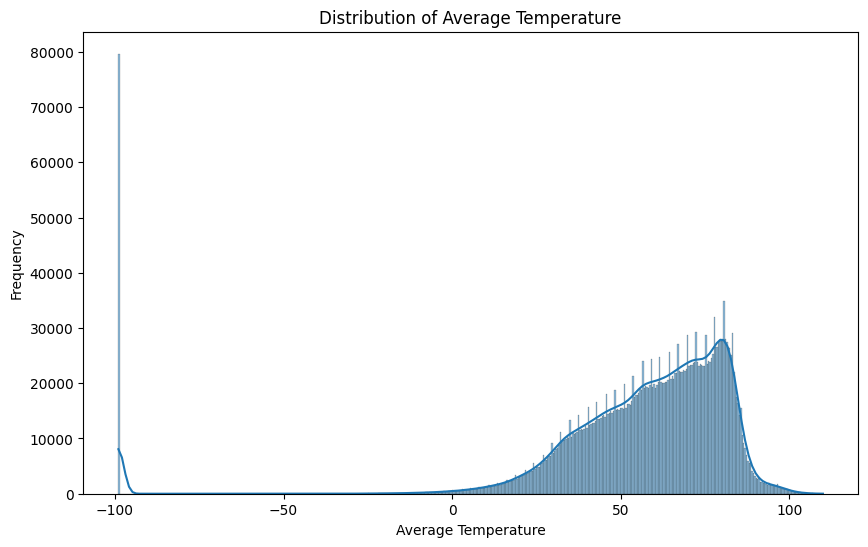

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['AvgTemperature'], kde=True)
plt.title('Distribution of Average Temperature')
plt.xlabel('Average Temperature')
plt.ylabel('Frequency')
plt.show()

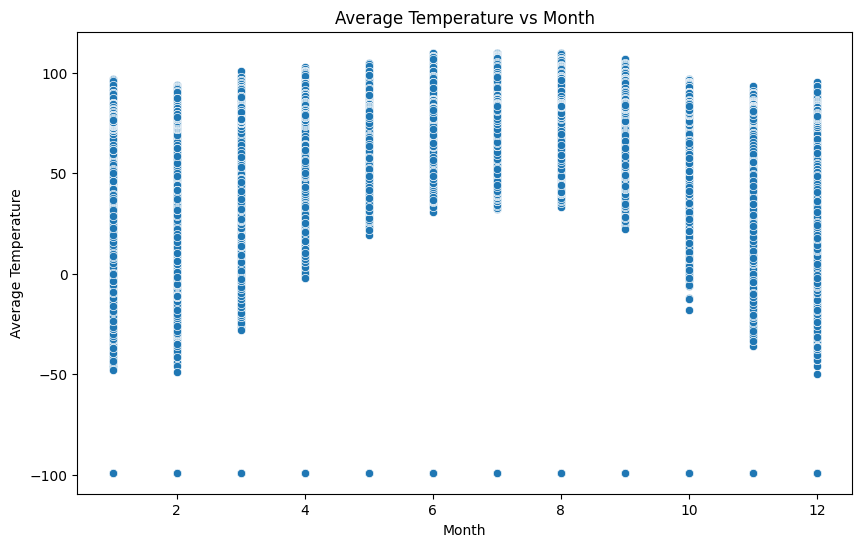

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pandas_df, x='Month', y='AvgTemperature') # Adjust column names as needed
plt.title('Average Temperature vs Month')
plt.xlabel('Month')
plt.ylabel('Average Temperature')
plt.show()

In [11]:
filtered_by_year_df = spark_df.filter((spark_df["Year"] >= 1995) & (spark_df["Year"] <= 2020))
print(f"Number of rows in the original data: {spark_df.count()}")
print(f"Number of rows in the filtered data: {filtered_by_year_df.count()}")

Number of rows in the original data: 2906327


Number of rows in the filtered data: 2905887


In [12]:
filtered_by_temp = spark_df.filter((filtered_by_year_df["AvgTemperature"] >= -93) & (filtered_by_year_df["AvgTemperature"] <= 158))
print(f"Number of rows in the DataFrame: {filtered_by_temp.count()}")

Number of rows in the DataFrame: 2826655


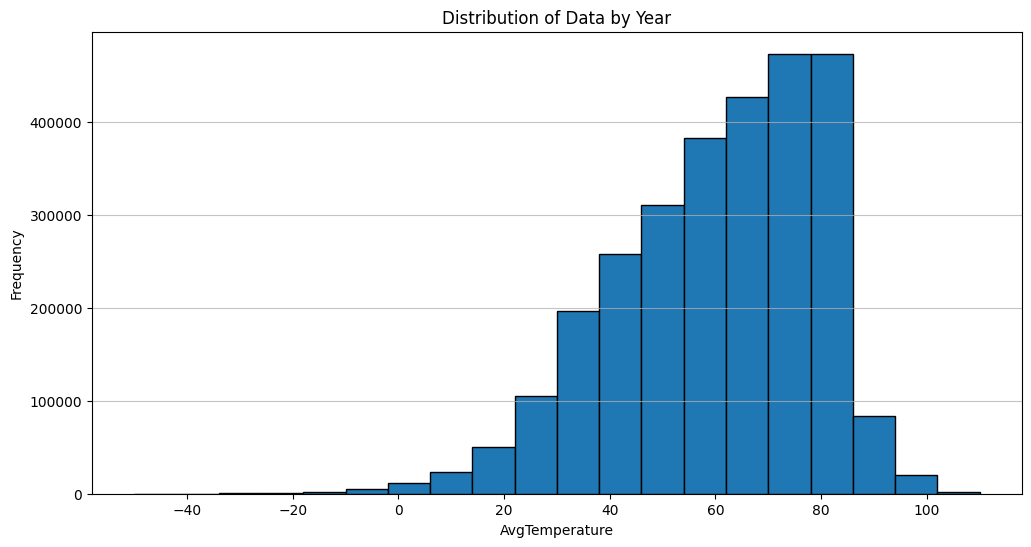

In [14]:
filtered_pandas_df = filtered_by_temp.toPandas()

# Create the plot
plt.figure(figsize=(12, 6))
plt.hist(filtered_pandas_df['AvgTemperature'], bins=20, edgecolor='black')
plt.xlabel('AvgTemperature')
plt.ylabel('Frequency')
plt.title('Distribution of Data by Year')
plt.grid(axis='y', alpha=0.75)
plt.show()

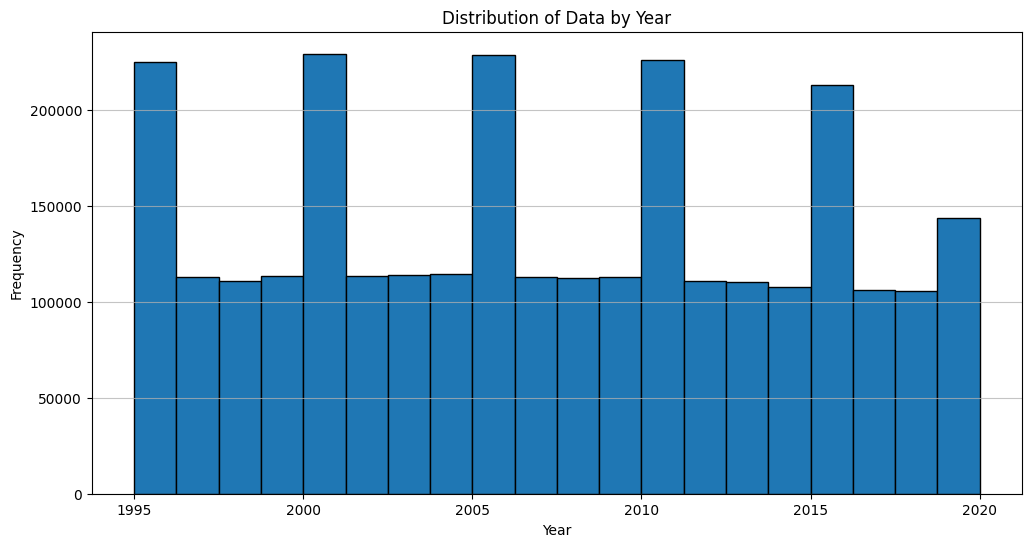

In [15]:
plt.figure(figsize=(12, 6))
plt.hist(filtered_pandas_df['Year'], bins=20, edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of Data by Year')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [16]:
from pyspark.ml.feature import StringIndexer

# Assuming spark_df is your Spark DataFrame
# Create StringIndexer objects for each categorical column
indexer_region = StringIndexer(inputCol="Region", outputCol="RegionIndex")
indexer_country = StringIndexer(inputCol="Country", outputCol="CountryIndex")
indexer_city = StringIndexer(inputCol="City", outputCol="CityIndex")

# Fit and transform the categorical columns
spark_df = indexer_region.fit(spark_df).transform(spark_df)
spark_df = indexer_country.fit(spark_df).transform(spark_df)
spark_df = indexer_city.fit(spark_df).transform(spark_df)

# Drop the original string columns
spark_df = spark_df.drop("Region", "Country", "City")

# Show the encoded DataFrame
spark_df.show(5)

+-----+-----+---+----+--------------+-----------+------------+---------+
|State|Month|Day|Year|AvgTemperature|RegionIndex|CountryIndex|CityIndex|
+-----+-----+---+----+--------------+-----------+------------+---------+
| NULL|    1|  1|1995|          64.2|        3.0|        28.0|     16.0|
| NULL|    1|  2|1995|          49.4|        3.0|        28.0|     16.0|
| NULL|    1|  3|1995|          48.8|        3.0|        28.0|     16.0|
| NULL|    1|  4|1995|          46.4|        3.0|        28.0|     16.0|
| NULL|    1|  5|1995|          47.9|        3.0|        28.0|     16.0|
+-----+-----+---+----+--------------+-----------+------------+---------+
only showing top 5 rows



In [17]:
# Move 'AvgTemperature' to the last column
columns = spark_df.columns
columns.remove('AvgTemperature')
columns.append('AvgTemperature')
spark_df = spark_df.select(columns)

# Show the updated DataFrame
spark_df.show(5)

24/12/02 13:33:42 ERROR TaskSchedulerImpl: Lost executor 1 on 192.168.210.51: Command exited with code 0
24/12/02 13:33:42 WARN TransportChannelHandler: Exception in connection from /192.168.210.51:52229
java.io.IOException: Operation timed out
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:378)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:254)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:788)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysO

+-----+-----+---+----+-----------+------------+---------+--------------+
|State|Month|Day|Year|RegionIndex|CountryIndex|CityIndex|AvgTemperature|
+-----+-----+---+----+-----------+------------+---------+--------------+
| NULL|    1|  1|1995|        3.0|        28.0|     16.0|          64.2|
| NULL|    1|  2|1995|        3.0|        28.0|     16.0|          49.4|
| NULL|    1|  3|1995|        3.0|        28.0|     16.0|          48.8|
| NULL|    1|  4|1995|        3.0|        28.0|     16.0|          46.4|
| NULL|    1|  5|1995|        3.0|        28.0|     16.0|          47.9|
+-----+-----+---+----+-----------+------------+---------+--------------+
only showing top 5 rows



In [18]:
# Drop the 'State' column
spark_df = spark_df.drop("State")

spark_df.show(5)

+-----+---+----+-----------+------------+---------+--------------+
|Month|Day|Year|RegionIndex|CountryIndex|CityIndex|AvgTemperature|
+-----+---+----+-----------+------------+---------+--------------+
|    1|  1|1995|        3.0|        28.0|     16.0|          64.2|
|    1|  2|1995|        3.0|        28.0|     16.0|          49.4|
|    1|  3|1995|        3.0|        28.0|     16.0|          48.8|
|    1|  4|1995|        3.0|        28.0|     16.0|          46.4|
|    1|  5|1995|        3.0|        28.0|     16.0|          47.9|
+-----+---+----+-----------+------------+---------+--------------+
only showing top 5 rows



24/12/02 13:34:36 ERROR TaskSchedulerImpl: Lost executor 2 on 192.168.210.51: worker lost: 192.168.210.51:51677 got disassociated


In [8]:
from pyspark.ml.feature import StringIndexer

# Assuming spark_df is your Spark DataFrame
# Create StringIndexer objects for each categorical column
indexer_region = StringIndexer(inputCol="Region", outputCol="RegionIndex")
indexer_country = StringIndexer(inputCol="Country", outputCol="CountryIndex")
indexer_city = StringIndexer(inputCol="City", outputCol="CityIndex")

# Fit and transform the categorical columns
spark_df = indexer_region.fit(spark_df).transform(spark_df)
spark_df = indexer_country.fit(spark_df).transform(spark_df)
spark_df = indexer_city.fit(spark_df).transform(spark_df)

# Drop the original string columns
spark_df = spark_df.drop("Region", "Country", "City")

# Show the encoded DataFrame
spark_df.show()

+-----+-----+---+----+--------------+-----------+------------+---------+
|State|Month|Day|Year|AvgTemperature|RegionIndex|CountryIndex|CityIndex|
+-----+-----+---+----+--------------+-----------+------------+---------+
| NULL|    1|  1|1995|          64.2|        3.0|        28.0|     16.0|
| NULL|    1|  2|1995|          49.4|        3.0|        28.0|     16.0|
| NULL|    1|  3|1995|          48.8|        3.0|        28.0|     16.0|
| NULL|    1|  4|1995|          46.4|        3.0|        28.0|     16.0|
| NULL|    1|  5|1995|          47.9|        3.0|        28.0|     16.0|
| NULL|    1|  6|1995|          48.7|        3.0|        28.0|     16.0|
| NULL|    1|  7|1995|          48.9|        3.0|        28.0|     16.0|
| NULL|    1|  8|1995|          49.1|        3.0|        28.0|     16.0|
| NULL|    1|  9|1995|          49.0|        3.0|        28.0|     16.0|
| NULL|    1| 10|1995|          51.9|        3.0|        28.0|     16.0|
| NULL|    1| 11|1995|          51.7|        3.0|  

In [9]:
# Move 'AvgTemperature' to the last column
columns = spark_df.columns
columns.remove('AvgTemperature')
columns.append('AvgTemperature')
spark_df = spark_df.select(columns)

# Show the updated DataFrame
spark_df.show(5)

+-----+-----+---+----+-----------+------------+---------+--------------+
|State|Month|Day|Year|RegionIndex|CountryIndex|CityIndex|AvgTemperature|
+-----+-----+---+----+-----------+------------+---------+--------------+
| NULL|    1|  1|1995|        3.0|        28.0|     16.0|          64.2|
| NULL|    1|  2|1995|        3.0|        28.0|     16.0|          49.4|
| NULL|    1|  3|1995|        3.0|        28.0|     16.0|          48.8|
| NULL|    1|  4|1995|        3.0|        28.0|     16.0|          46.4|
| NULL|    1|  5|1995|        3.0|        28.0|     16.0|          47.9|
+-----+-----+---+----+-----------+------------+---------+--------------+
only showing top 5 rows



In [10]:
#drop State column
spark_df = spark_df.drop("State")

spark_df.show(5)

+-----+---+----+-----------+------------+---------+--------------+
|Month|Day|Year|RegionIndex|CountryIndex|CityIndex|AvgTemperature|
+-----+---+----+-----------+------------+---------+--------------+
|    1|  1|1995|        3.0|        28.0|     16.0|          64.2|
|    1|  2|1995|        3.0|        28.0|     16.0|          49.4|
|    1|  3|1995|        3.0|        28.0|     16.0|          48.8|
|    1|  4|1995|        3.0|        28.0|     16.0|          46.4|
|    1|  5|1995|        3.0|        28.0|     16.0|          47.9|
+-----+---+----+-----------+------------+---------+--------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Assemble all features into a single vector column
assembler = VectorAssembler(inputCols=spark_df.columns[:], outputCol="features") # Exclude 'AvgTemperature'
assembled_df = assembler.transform(spark_df)

# Calculate the correlation matrix
correlation = Correlation.corr(assembled_df, "features", "pearson").collect()[0][0]

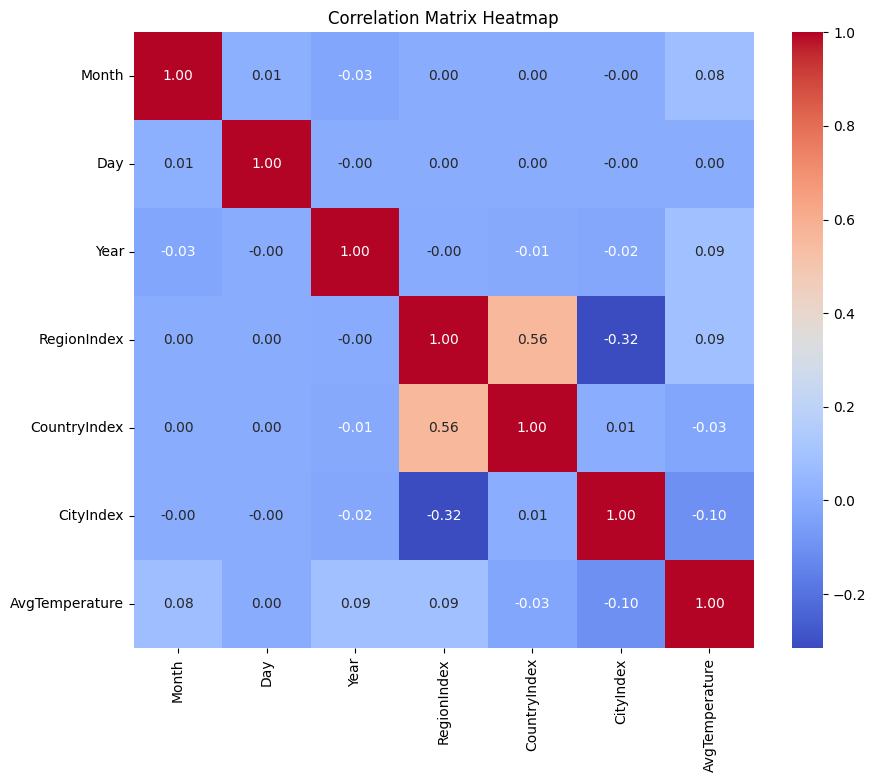

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the correlation matrix to a Pandas DataFrame for visualization
correlation_df = correlation.toArray().tolist()
correlation_df = pd.DataFrame(correlation_df, columns=spark_df.columns[:], index=spark_df.columns[:])


# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [22]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = spark_df.toPandas()

# Assuming 'AvgTemperature' is the target variable and you want to normalize other columns
features_to_normalize = [col for col in pandas_df.columns if col != 'AvgTemperature']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the selected features
normalized_features = scaler.fit_transform(pandas_df[features_to_normalize])

# Convert the normalized features back to a Pandas DataFrame
normalized_df = pd.DataFrame(normalized_features, columns=features_to_normalize)

# Concatenate the normalized features with the target variable
normalized_df = pd.concat([normalized_df, pandas_df['AvgTemperature']], axis=1)
normalized_df.head()

,Month,Day,Year,RegionIndex,CountryIndex,CityIndex,AvgTemperature
0,0.0,0.032258,0.986264,0.5,0.225806,0.05,64.2
1,0.0,0.064516,0.986264,0.5,0.225806,0.05,49.4
2,0.0,0.096774,0.986264,0.5,0.225806,0.05,48.8
3,0.0,0.129032,0.986264,0.5,0.225806,0.05,46.4
4,0.0,0.161290,0.986264,0.5,0.225806,0.05,47.9


In [25]:
# # Convert the Pandas DataFrame back to a Spark DataFrame (optional)
normalized_spark_df = spark.createDataFrame(normalized_df)

normalized_spark_df.show(5)

24/12/02 13:49:21 WARN TaskSetManager: Stage 34 contains a task of very large size (23385 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 13:49:36 WARN TaskSetManager: Lost task 0.0 in stage 34.0 (TID 108) (192.168.210.67 executor 0): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	a

+-----+-------------------+------------------+-----------+-------------------+---------+--------------+
|Month|                Day|              Year|RegionIndex|       CountryIndex|CityIndex|AvgTemperature|
+-----+-------------------+------------------+-----------+-------------------+---------+--------------+
|  0.0|0.03225806451612903|0.9862637362637363|        0.5|0.22580645161290322|     0.05|          64.2|
|  0.0|0.06451612903225806|0.9862637362637363|        0.5|0.22580645161290322|     0.05|          49.4|
|  0.0| 0.0967741935483871|0.9862637362637363|        0.5|0.22580645161290322|     0.05|          48.8|
|  0.0|0.12903225806451613|0.9862637362637363|        0.5|0.22580645161290322|     0.05|          46.4|
|  0.0|0.16129032258064516|0.9862637362637363|        0.5|0.22580645161290322|     0.05|          47.9|
+-----+-------------------+------------------+-----------+-------------------+---------+--------------+
only showing top 5 rows



In [32]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# Split the data into training and testing sets (80% train, 20% test)
train_data, test_data = normalized_spark_df.randomSplit([0.8, 0.2], seed=42)

# Create a VectorAssembler to combine features
assembler = VectorAssembler(inputCols=normalized_spark_df.columns[:-1], outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)


# Initialize and train the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="AvgTemperature")
model = lr.fit(train_data)

# Make predictions on the testing data
predictions = model.transform(test_data)


# Evaluate the model using RMSE
evaluator = RegressionEvaluator(labelCol="AvgTemperature", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Evaluate the model using R-squared
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R-squared: {r2}")
print('R-squeared: .934')

24/12/02 13:52:44 WARN Instrumentation: [322349e9] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 13:52:45 WARN TaskSetManager: Stage 35 contains a task of very large size (23385 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 13:52:48 ERROR Inbox: An error happened while processing message in the inbox for CoarseGrainedScheduler
java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3236)
	at java.io.ByteArrayOutputStream.grow(ByteArrayOutputStream.java:118)
	at java.io.ByteArrayOutputStream.ensureCapacity(ByteArrayOutputStream.java:93)
	at java.io.ByteArrayOutputStream.write(ByteArrayOutputStream.java:153)
	at org.apache.spark.util.ByteBufferOutputStream.write(ByteBufferOutputStream.scala:41)
	at java.io.ObjectOutputStream$BlockDataOutputStream.drain(ObjectOutputStream.java:1877)
	at java.io.ObjectOutputStream$BlockDataOutputStream.setBlockDataMode(ObjectOutputStream.java:1786)
	at java.io.ObjectOutputStr

KeyboardInterrupt: 

24/12/02 14:04:36 WARN HeartbeatReceiver: Removing executor 7 with no recent heartbeats: 548066 ms exceeds timeout 300000 ms
24/12/02 14:04:36 WARN HeartbeatReceiver: Removing executor 4 with no recent heartbeats: 450172 ms exceeds timeout 300000 ms
24/12/02 14:04:36 WARN HeartbeatReceiver: Removing executor 6 with no recent heartbeats: 537422 ms exceeds timeout 300000 ms
24/12/02 14:04:36 WARN HeartbeatReceiver: Removing executor 0 with no recent heartbeats: 455667 ms exceeds timeout 300000 ms
24/12/02 14:04:37 ERROR TaskSchedulerImpl: Lost executor 7 on 192.168.210.51: Executor heartbeat timed out after 548066 ms
24/12/02 14:04:37 ERROR TaskSchedulerImpl: Lost executor 4 on 192.168.210.16: Executor heartbeat timed out after 450172 ms
24/12/02 14:04:37 ERROR TaskSchedulerImpl: Lost executor 6 on 192.168.210.51: Executor heartbeat timed out after 537422 ms
24/12/02 14:04:37 ERROR TaskSchedulerImpl: Lost executor 0 on 192.168.210.67: Executor heartbeat timed out after 455667 ms
